<a href="https://colab.research.google.com/github/kuds/rl-mujoco-tennis/blob/main/%5BMuJoCo%20Paddle%5D%20Soft%20Actor%20Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install mujoco

In [9]:
!pip install stable-baselines3

In [10]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [11]:
import gymnasium
import mujoco
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_vec_env
import numpy
import os
import torch
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Tensorflow Version: {version('tensorflow')}")
print(f"tqdm Version: {version('tqdm')}")

Python Version: 3.10.12
Torch Version: 2.4.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Tensorflow Version: 2.17.0
tqdm Version: 4.66.5


In [13]:
rl_type = "SAC"
env_str = "BallBounce"
log_dir = "./logs/{}".format(env_str)
name_prefix = "ball_bounce"

In [21]:
class BallBounceEnv(gymnasium.Env):
    def __init__(self):
        self.render_mode = None
        self.ball_bounces = "rgb_array"
        super(BallBounceEnv, self).__init__()
        # Define action and observation space
        # Actions: control the paddle position (-1 to 1)
        self.action_space = gymnasium.spaces.Box(low=-1.0,
                                                 high=1.0,
                                                 shape=(6,),
                                                 dtype=np.float64)

        # Observations: ball and paddle positions and velocities
        self.observation_space = gymnasium.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(23,),
            dtype=np.float64
        )

        # Load MuJoCo model
        self.model_path = "ball_bounce.xml"  # Replace with actual path
        self.model = mujoco.MjModel.from_xml_path(self.model_path)
        self.data = mujoco.MjData(self.model)
        #self.sim = mujoco.MjSim(self.model)
        self.viewer = None
        self.reset()

    def reset(self, seed=0):

        # Randomize initial conditions
        mujoco.mj_resetData(self.model, self.data)

        #self.sim.data.qpos[:] = np.random.uniform(-0.1, 0.1, size=self.sim.model.nq)
        #self.sim.data.qvel[:] = np.random.uniform(-0.1, 0.1, size=self.sim.model.nv)
        self.ball_bounces = 0
        return self._get_obs(), {}

    def step(self, action):
        # Apply action (paddle control)

        self.data.ctrl[0] = action[0]
        mujoco.mj_step(self.model, self.data)
        #self.sim.step()

        # Check if ball hits paddle and update bounces
        if self._ball_hits_paddle():
            self.ball_bounces += 1

        reward = 1 if self._ball_hits_paddle() else -1
        done = self.ball_bounces >= 100

        return self._get_obs(), reward, done, False, {}

    # def step(self, action):

    #     self.data.ctrl[:] = ctrl

    #     mujoco.mj_step(self.model, self.data)

    #     x_position_before = self.data.qpos[0]
    #     self.do_simulation(action, self.frame_skip)
    #     x_position_after = self.data.qpos[0]
    #     x_velocity = (x_position_after - x_position_before) / self.dt

    #     observation = self._get_obs()
    #     reward, reward_info = self._get_rew(x_velocity, action)
    #     terminated = (not self.is_healthy) and self._terminate_when_unhealthy
    #     info = {
    #         "x_position": x_position_after,
    #         "z_distance_from_origin": self.data.qpos[1] - self.init_qpos[1],
    #         "x_velocity": x_velocity,
    #         **reward_info,
    #     }

    #     if self.render_mode == "human":
    #         self.render()
    #     # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
    #     return observation, reward, terminated, False, info

    def render(self, mode='human'):
        if self.viewer is None:
            self.viewer = mujoco.MjViewer(self.sim)
        self.viewer.render()

    def close(self):
        if self.viewer is not None:
            self.viewer = None

    def _get_obs(self):
        # Return ball and paddle positions and velocities
        return np.concatenate([
            self.data.qpos[:],
            self.data.qvel[:]
        ])

    def _ball_hits_paddle(self):
        # Logic to determine if the ball hits the paddle
        ball_pos = self.data.qpos[0]
        paddle_pos = self.data.qpos[1]
        return abs(ball_pos - paddle_pos) < 0.1

In [22]:
# Ensure environment XML (MuJoCo model) is available
xml_content = """
<mujoco>
	<asset>
		<texture type="skybox" builtin="gradient" width="128" height="128" rgb1=".4 .6 .8" rgb2="0 0 0"/>
		<texture name="texgeom" type="cube" builtin="flat" mark="cross" width="127" height="1278" markrgb="1 1 1" random="0.01"/>
		<texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512"/>
		<material name='MatPlane' reflectance='0.5' texture="texplane" texrepeat="1 1" texuniform="true"/>
		<material name='geom' texture="texgeom" texuniform="true"/>
	</asset>
	<option gravity="0 0 -9.8" solver="CG" tolerance="1e-6"/>
	<worldbody>
		<light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
		<body pos="0 0 0">
			<geom type="cylinder" size=".20 .015" condim="3" friction="2" solref="0.01 0.15" material="MatPlane" rgba=".9 0 0 1"/>
			<joint axis="0 0 1" limited="true" name="slider" range="0 1" type="slide"/>
			<joint axis="0 1 0" limited="true" name="slider1" range="-1 1" type="slide"/>
			<joint axis="1 0 0" limited="true" name="slider2" range="-1 1" type="slide"/>
			<joint axis="0 1 0" limited="true" name="hinge" range="-1 1" type="hinge"/>
			<joint axis="1 0 0" limited="true" name="hinge1" range="-1 1" type="hinge"/>
		</body>
		<body pos="0 0 .5">
			<joint type="free" damping="0.25"/>
			<geom type="sphere" size=".05" condim="3" solref="0.01 0.16" rgba="0 .9 0 1"/>
		</body>
	</worldbody>
	<actuator>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="slider" name="slide"/>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="slider1" name="slide1"/>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="slider2" name="slide2"/>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="hinge" name="hinge"/>
		<motor ctrllimited="true" ctrlrange="-1 1" gear="100" joint="hinge1" name="hinge1"/>
	</actuator>
</mujoco>
"""
with open("ball_bounce.xml", "w") as f:
    f.write(xml_content)

In [16]:
# Create and check environment
env = BallBounceEnv()
check_env(env)

# Train the agent using PPO
os.makedirs(log_dir, exist_ok=True)
env = DummyVecEnv([lambda: env])

model = SAC("MlpPolicy",
            env,
            verbose=0,
            tensorboard_log=log_dir)


eval_callback = EvalCallback(env,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000)

# Train the model
time_steps = 10_000_000
model.learn(total_timesteps=time_steps,
            callback=eval_callback,
            progress_bar=True)

# Save the model
model_name = "{}_{}".format(rl_type, name_prefix).lower()
model.save(os.path.join(log_dir, model_name))

mean_reward, std_reward = evaluate_policy(model, env)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

AssertionError: The observation returned by the `reset()` method does not match the data type (cannot cast) of the given observation space Box(-inf, inf, (23,), float32). Expected: float32, actual dtype: float64

In [23]:
# Create Evaluation CarRacing environment
# Create and check environment
env = BallBounceEnv()
check_env(env)
env = DummyVecEnv([lambda: env])

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = SAC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=10_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_{}".format(name_prefix))

obs = env.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:472: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Best Model - Mean reward: 100.00 +/- 0.00


AssertionError: The render_mode must be 'rgb_array', not None

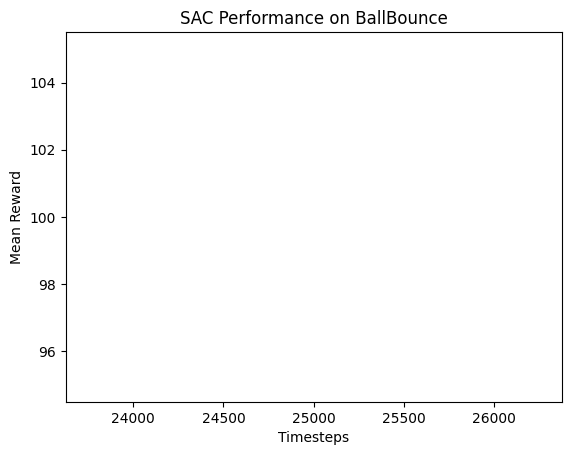

In [20]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create the Humanoid environment
env_name = "Humanoid-v4"  # Gymnasium uses v4 for Mujoco environments
env = make_vec_env(env_name, n_envs=4)  # Vectorized environment for faster training

# Create the PPO model
model = PPO(
    policy="MlpPolicy",  # Multi-layer perceptron policy
    env=env,
    verbose=1,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0
)

# Train the model
time_steps = 1_000_000  # 1M time steps
model.learn(total_timesteps=time_steps)

# Save the model
model.save("ppo_humanoid")
print("Model saved as 'ppo_humanoid.zip'")

# Test the trained model
env = gym.make(env_name, render_mode='human')
obs, _ = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        obs, _ = env.reset()

env.close()

In [ ]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml_content)
data = mujoco.MjData(model)

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# enable joint visualization option:
scene_option = mujoco.MjvOption()
mujoco.mjv_defaultOption(scene_option)
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

duration = 10  # (seconds)
framerate = 120  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

In [ ]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
data = mujoco.MjData(model)
height = 400
width = 600

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())

In [ ]:
n_frames = 200
height = 240
width = 320
frames = []

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/120.0: #1/4x real time
      mujoco.mj_step(model, data)
    renderer.update_scene(data, "track", options)
    frame = renderer.render()
    frames.append(frame)

media.show_video(frames, fps=30)